In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, Audio
from sklearn.metrics import classification_report

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理和加载
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),                  # 随机水平翻转
    transforms.RandomCrop(32, padding=4),               # 随机裁剪并填充
    transforms.RandomRotation(15),                      # 随机旋转 15 度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 下载并加载数据集
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 将训练集划分为训练集和验证集（90% 用于训练，10% 用于验证）
train_size = int(0.9 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# 定义一个简化的 VGG 模型
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 模型、损失函数和优化器
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 训练模型函数，增加验证集的损失计算
def train_model_with_logs(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=3):
    best_loss = float('inf')
    trigger_times = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # 计算训练准确率
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # 记录训练损失和准确率
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # 调整学习率
        scheduler.step()

        # 在验证集上测试损失和准确率
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # 计算验证准确率
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1} Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%, "
              f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.2f}%")

        # 早停检查
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0  # 重置耐心计数器
        else:
            trigger_times += 1
            print(f"Early stopping trigger times: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("Early stopping")
                break

    # 绘制训练曲线
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Training Complete")


# 测试模型函数
def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

# 单张图像显示函数
def imshow(img):
    img = img / 2 + 0.5  # 去归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机选择一张图像进行预测
def predict_single_image():
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    print('真实标签: ', ' '.join(f'{labels[j]}' for j in range(4)))
    imshow(torchvision.utils.make_grid(images[:4]))

    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('预测标签: ', ' '.join(f'{predicted[j]}' for j in range(4)))

# 改进后的预测函数
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def predict_test_set_with_report(model, testloader, device, class_names):
    model.eval()  # 设置模型为评估模式
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # 禁用梯度计算，加速预测
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # 收集所有真实标签和预测标签
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 生成分类报告
    print("\nClassification Report:")
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print(report)

    return report



def play_simple_beep():
    # 生成1秒钟的440Hz的音调
    framerate = 44100
    duration = 1
    t = np.linspace(0, duration, int(framerate * duration))
    sound = np.sin(2 * np.pi * 440 * t)  # 440Hz 为标准音调A4
    display(Audio(sound, rate=framerate, autoplay=True))

Files already downloaded and verified
Files already downloaded and verified


Training the model...
Epoch 1 Train Loss: 1.615, Train Accuracy: 40.15%, Validation Loss: 1.324, Validation Accuracy: 51.16%
Epoch 2 Train Loss: 1.195, Train Accuracy: 57.38%, Validation Loss: 1.179, Validation Accuracy: 59.38%
Epoch 3 Train Loss: 0.999, Train Accuracy: 65.14%, Validation Loss: 1.004, Validation Accuracy: 64.04%
Epoch 4 Train Loss: 0.878, Train Accuracy: 69.58%, Validation Loss: 0.858, Validation Accuracy: 70.04%
Epoch 5 Train Loss: 0.790, Train Accuracy: 72.81%, Validation Loss: 0.834, Validation Accuracy: 70.94%
Epoch 6 Train Loss: 0.721, Train Accuracy: 75.51%, Validation Loss: 0.753, Validation Accuracy: 74.26%
Epoch 7 Train Loss: 0.672, Train Accuracy: 77.24%, Validation Loss: 0.690, Validation Accuracy: 75.74%
Epoch 8 Train Loss: 0.620, Train Accuracy: 78.94%, Validation Loss: 0.600, Validation Accuracy: 79.48%
Epoch 9 Train Loss: 0.589, Train Accuracy: 80.20%, Validation Loss: 0.574, Validation Accuracy: 81.00%
Epoch 10 Train Loss: 0.545, Train Accuracy: 81.66%,

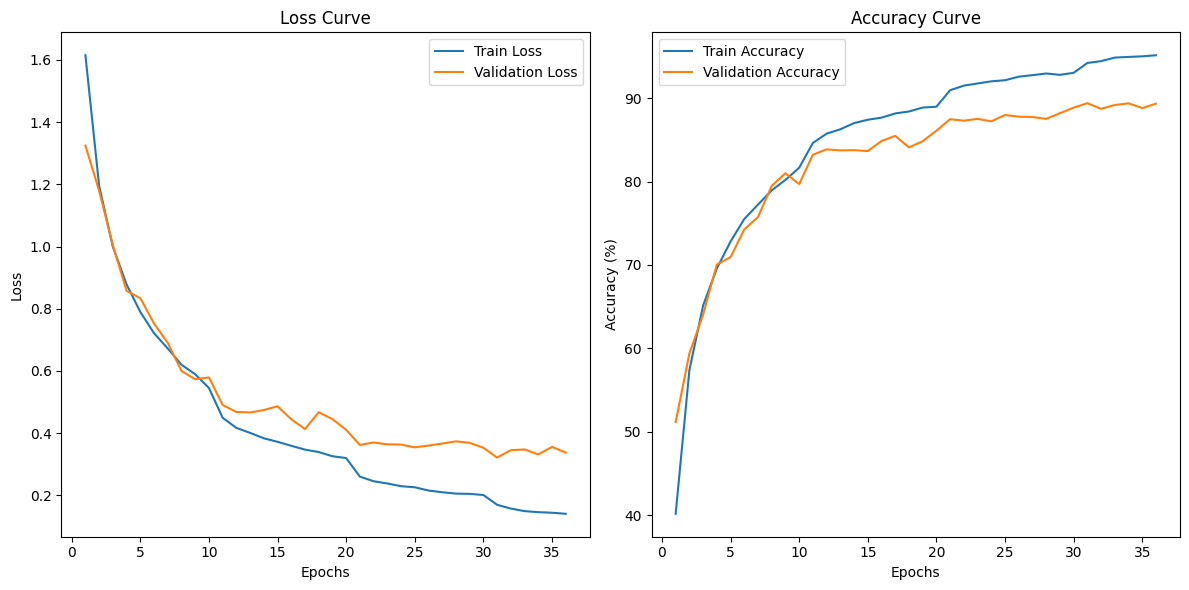

Training Complete

Testing the model...

Generating classification report...

Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.91      0.93      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.89      0.89      1000
         cat       0.83      0.82      0.82      1000
        deer       0.93      0.92      0.92      1000
         dog       0.87      0.88      0.87      1000
        frog       0.96      0.95      0.95      1000
       horse       0.94      0.95      0.94      1000
        ship       0.95      0.96      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Model saved as 'vgg_model_1.pth'.


Total execution time: 2195.98 seconds


In [3]:
if __name__ == '__main__':
    # 记录开始时间
    start_time = time.time()
    
    # 训练模型
    print("Training the model...")
    train_model_with_logs(model, trainloader, valloader, criterion, optimizer, scheduler, epochs=50, patience=5)

    # 测试模型并生成分类报告
    print("\nTesting the model...")
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print("\nGenerating classification report...")
    classification_report_output = predict_test_set_with_report(model, testloader, device, class_names)
    
    # 保存模型
    torch.save(model.state_dict(), 'vgg_model_1.pth')
    print("Model saved as 'vgg_model_1.pth'.")

    # 播放提示音
    play_simple_beep()
    
    # 记录结束时间并计算总时长
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # 打印执行时间
    print(f"Total execution time: {elapsed_time:.2f} seconds")
